In [18]:
import numpy as np
import emcee
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp,odeint
import astropy.coordinates as coord
import astropy.units as u
import corner
import matplotlib.pyplot as plt
import multiprocessing

In [34]:
# 常量
G = 43018  # 引力常数，单位：kpc (km/s)^2 / 10^10 Msun

def rotation_matrix_x(theta):
    """
    绕 x 轴旋转的旋转矩阵 (角度 theta)
    参数:
        theta: 绕 x 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    
def rotation_matrix_y(phi):
    """
    绕 y 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 y 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

def rotation_matrix_z(phi):
    """
    绕 z 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 z 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

#坐标系转换
def Galactic_to_icrs(pos,vel):
    gc = coord.SkyCoord(x= pos[0]* u.kpc, y=pos[1]* u.kpc,
            z= pos[2]* u.kpc,
            v_x= vel[0]* u.km / u.s,
            v_y= vel[1]* u.km / u.s,
            v_z= vel[2]* u.km / u.s, frame='galactocentric',
            representation_type='cartesian', differential_type='cartesian',
            galcen_distance=8.122* u.kpc, z_sun=20.8 * u.pc,
            galcen_v_sun=coord.CartesianDifferential(
                 [12.9, 245.6, 7.8] * u.km / u.s))
    c = gc.transform_to(coord.ICRS)
    ra = np.array(c.ra)
    dec = np.array(c.dec)
    distance = np.array(c.distance)
    pmra = np.array(c.pm_ra_cosdec)
    pmdec = np.array(c.pm_dec)
    vr = np.array(c.radial_velocity)
    return ra, dec, distance, pmra, pmdec, vr

# 定义二体问题的微分方程
def two_body_equation(y, t, M):
    """
    二体问题的微分方程
    参数:
        t: 时间 (Gyr)
        y: 状态向量 [x, y, z, vx, vy, vz]
        M: 中心天体质量 (10^10 Msun)
    返回:
        dydt: 状态向量的导数 [vx, vy, vz, ax, ay, az]
    """
    x, y, z, vx, vy, vz = y
    r = np.sqrt(x**2 + y**2 + z**2)
    ax = -G * M * x / r**3 + x*0.07**2*0.7
    ay = -G * M * y / r**3 + y*0.07**2*0.7
    az = -G * M * z / r**3 + z*0.07**2*0.7
    return [vx, vy, vz, ax, ay, az]

# 定义运动学模型
def orbit_model(params):
    """
    根据轨道参数计算 r, v_rad, v_tan
    参数:
        params: [a, e, M, t_peri]，分别为半长轴、偏心率、总质量、近日点时间
        t_obs: 当前时间 (Gyr)
    返回:
        r: 距离 (kpc)
        v_rad: 径向速度 (km/s)
        v_tan: 切向速度 (km/s)
    """
    a, e, M, theta, phi, alpha = params

    
    # 微分方程的初始条件设置
    t_span = (0, 13.8)
    r0 = a * (1 - e )
    v_factor = np.sqrt(G * M / a)
    v_tan = v_factor * np.sqrt(1 - e**2) / (1 - e )
    # 计算坐标
    rot_matrix = np.dot(rotation_matrix_y(theta), np.dot(rotation_matrix_z(phi), rotation_matrix_x(alpha)))
    pos = np.dot(rot_matrix, np.array([r0, 0, 0]))
    vel = np.dot(rot_matrix, np.array([0, v_tan, 0]))
    
    
    #求解方程
    y0 = np.concatenate((pos, vel))

    t_eval = np.linspace(t_span[0], t_span[1], 2000)  # 时间点

    # 数值积分
    #solution = solve_ivp(two_body_equation, t_span, y0, args=(M,), rtol=1e-7, method='RK45')
    solution = odeint(two_body_equation, y0, t_eval, args=(M,))
    # 提取 t = T_uni 时的解
    final_pos = solution[-1, :3]  # 最后一列是位置 [x, y, z]
    final_vel = solution[-1, 3:]  # 最后一列是速度 [vx, vy, vz]

    # 转换为 ICRS 坐标
    ra, dec, distance, pmra, pmdec, vr = Galactic_to_icrs(final_pos, final_vel)
    
    return ra, dec, distance, pmra, pmdec, vr

# 定义似然函数
def log_likelihood(params, data, obs_err):
    """
    计算似然函数
    参数:
        params: 轨道参数 
        data: 观测数据，包括位置、速度等
    返回:
        似然值
    """
    # 从数据中提取观测值
    obs_ra, obs_dec, obs_distance, obs_pmra, obs_pmdec, obs_vr = data
    obs_ra_err, obs_dec_err, obs_distance_err, obs_pmra_err, obs_pmdec_err, obs_vr_err = obs_err
    
    # 计算模型值
    model_ra, model_dec, model_distance, model_pmra, model_pmdec, model_vr= orbit_model(params)
    
    # 计算似然
    chi2 = (model_ra - obs_ra)**2 / obs_ra_err**2 + \
        (model_dec - obs_dec)**2 / obs_dec_err**2 + \
        (model_distance - obs_distance)**2 / obs_distance_err**2 + \
        (model_pmra - obs_pmra)**2 / obs_pmra_err**2 + \
        (model_pmdec - obs_pmdec)**2 / obs_pmdec_err**2 + \
        (model_vr - obs_vr)**2 / obs_vr_err**2 

    return -0.5 * chi2

# 定义先验函数
def log_prior(params):
    """
    定义参数的先验分布
    参数:
        params: [M_LG, r, ln(1-e), eta, alpha]
    返回:
        log_prior: 对数先验值
    """
    a, e, M, theta, phi, alpha = params

    # 先验分布
    
    T =  np.sqrt(a**3 / (G * M))*2 * np.pi
    
    # M_LG: 正态分布 N(4.5e12, 3e12)
    
    if M <= 0 or T<=10:
        return -np.inf
    log_prior_M_LG = -0.5 * ((M - 400) / 300)**2

    # r: 正态分布 N(700, 100)
    if a <= 0 or T<=10:
        return -np.inf
    log_prior_r = -0.5 * ((a - 500) / 100)**2


    # ln(1-e): 均匀分布 U(-10, 0)
    if e < 0 or e >= 1:
        return -np.inf
    else:
        ln_1_minus_e = np.log(1 - e)
        if ln_1_minus_e < -10 or ln_1_minus_e > 0:
            return -np.inf
        log_prior_ln_1_minus_e = 0  # 均匀分布的对数先验为常数

    # theta: 均匀分布 U(0, pi)
    if theta < -np.pi or theta >np.pi:
        return -np.inf
    log_prior_theta = 0  # 均匀分布的对数先验为常数
    
    # phi: 均匀分布 U(0, pi)
    if phi < -np.pi/2 or phi > 0:
        return -np.inf
    log_prior_phi = 0  # 均匀分布的对数先验为常数
    
    # alpha: 均匀分布 U(-pi, pi)
    if alpha < 0 or alpha > 2*np.pi:
        return -np.inf
    log_prior_alpha = 0  # 均匀分布的对数先验为常数

    # # T_uni: 正态分布 N(0, 1)
    # if T_uni < 13.6 or T_uni > 14.:
    #     return -np.inf
    # log_prior_T_uni = -0.5 * ((T_uni - 13.8) / 0.1)**2

    # 总先验
    return log_prior_M_LG + log_prior_r + log_prior_ln_1_minus_e + log_prior_theta + log_prior_phi + log_prior_alpha 

def log_posterior(params, data, obs_errors):
    """
    计算后验分布
        log_posterior: 对数后验值
    """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, data, obs_errors)




In [35]:

obs_ra = 10.68
obs_ra_err = 0.1
obs_dec = 41.27
obs_dec_err = 0.1
obs_distance = 761
obs_distance_err = 11
obs_pmra = 46.9*1e-3
obs_pmra_err = 10*1e-3
obs_pmdec = -29.1*1e-3
obs_pmdec_err = 10*1e-3
obs_vr = -301
obs_vr_err = 1

data = [obs_ra, obs_dec, obs_distance, obs_pmra, obs_pmdec, obs_vr]
obs_err = [obs_ra_err, obs_dec_err, obs_distance_err, obs_pmra_err, obs_pmdec_err, obs_vr_err]

# MCMC 采样
ndim = 6  # 参数维度
nwalkers = 48  # walker 数量
nsteps = 5000  # 采样步数
ncores = 21  # CPU 核心数

# 初始参数
initial_guess = [500, 0.9, 400, -np.pi/4, -np.pi/4, 0]  # [a, e, M_LG, theta, phi, alpha, T_uni]
#5. 多核进行MCMC采样
with multiprocessing.Pool(ncores) as pool:
    pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim)
    # 使用 emcee 进行采样
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, obs_err), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)






  0%|          | 0/5000 [00:00<?, ?it/s]/home/guozx/anaconda3/envs/new_env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:46<00:00, 30.00it/s]


In [36]:
af = sampler.acceptance_fraction
af_mean = np.mean(af)*100
print(f"平均接受率: {af_mean:.2f}%")

平均接受率: 19.62%


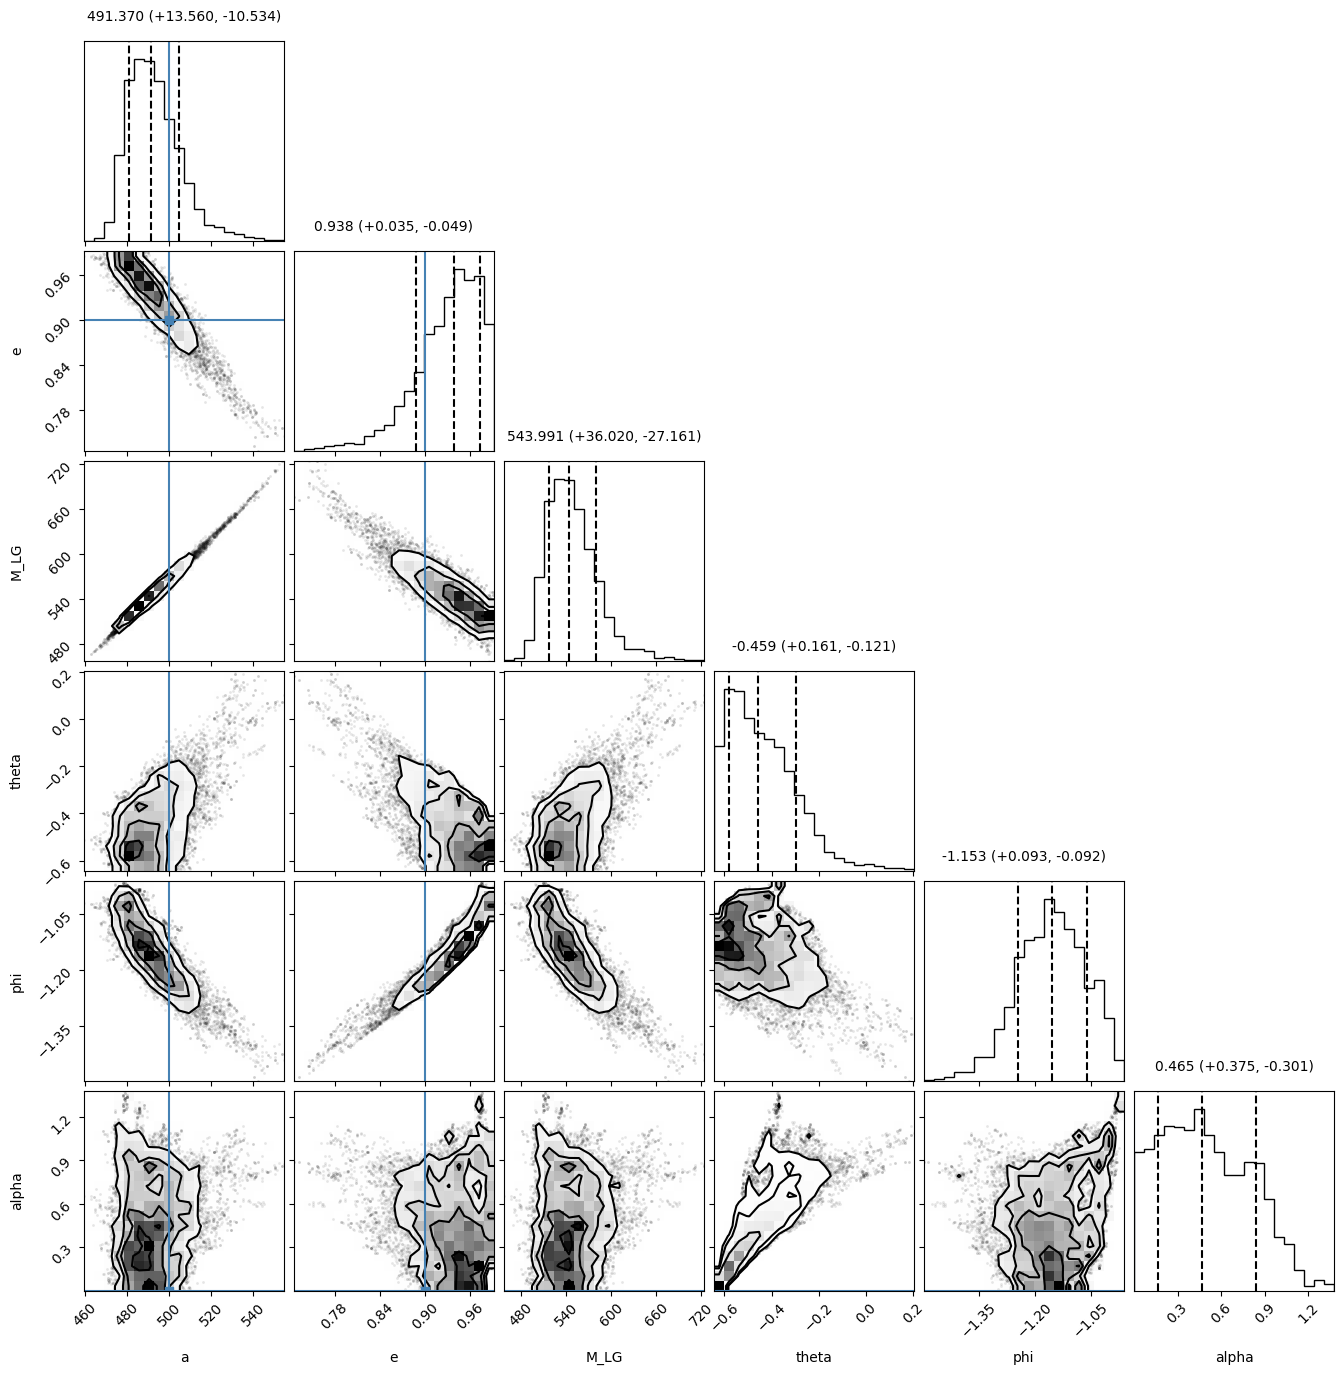

In [37]:
# 提取采样结果
burn_in = int(nsteps * 0.3) 
samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)

# 参数标签和初始猜测
labels = ["a", "e", "M_LG", "theta", "phi", "alpha"]

# 计算分位数
quantiles = [0.16, 0.5, 0.84]
percentiles = np.percentile(samples, [16, 50, 84], axis=0)

# 提取中位数和误差
medians = percentiles[1]
lower_errors = medians - percentiles[0]
upper_errors = percentiles[2] - medians

# 绘制角度分布
fig = corner.corner(samples, labels=labels, truths=initial_guess, quantiles=quantiles)

# 在图中添加中位数和误差信息
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(len(labels)):
    ax = axes[i, i]
    text = f"{medians[i]:.3f} (+{upper_errors[i]:.3f}, -{lower_errors[i]:.3f})"
    ax.annotate(text, xy=(0.5, 1.1), xycoords="axes fraction", ha="center", fontsize=10)

plt.show()

In [1]:
print(samples.shape)
n=11417
mod_ra = np.zeros(n)
mod_dec = np.zeros(n)
mod_distance = np.zeros(n)
mod_pmra = np.zeros(n)
mod_pmdec = np.zeros(n)
mod_vr = np.zeros(n)
for i in range(n):
    mod_ra[i], mod_dec[i], mod_distance[i], mod_pmra[i], mod_pmdec[i], mod_vr[i] = orbit_model(samples[i])





NameError: name 'samples' is not defined

In [15]:
mods = np.c_[mod_ra, mod_dec, mod_distance, mod_pmra, mod_pmdec, mod_vr]
mods.shape

(11417, 6)

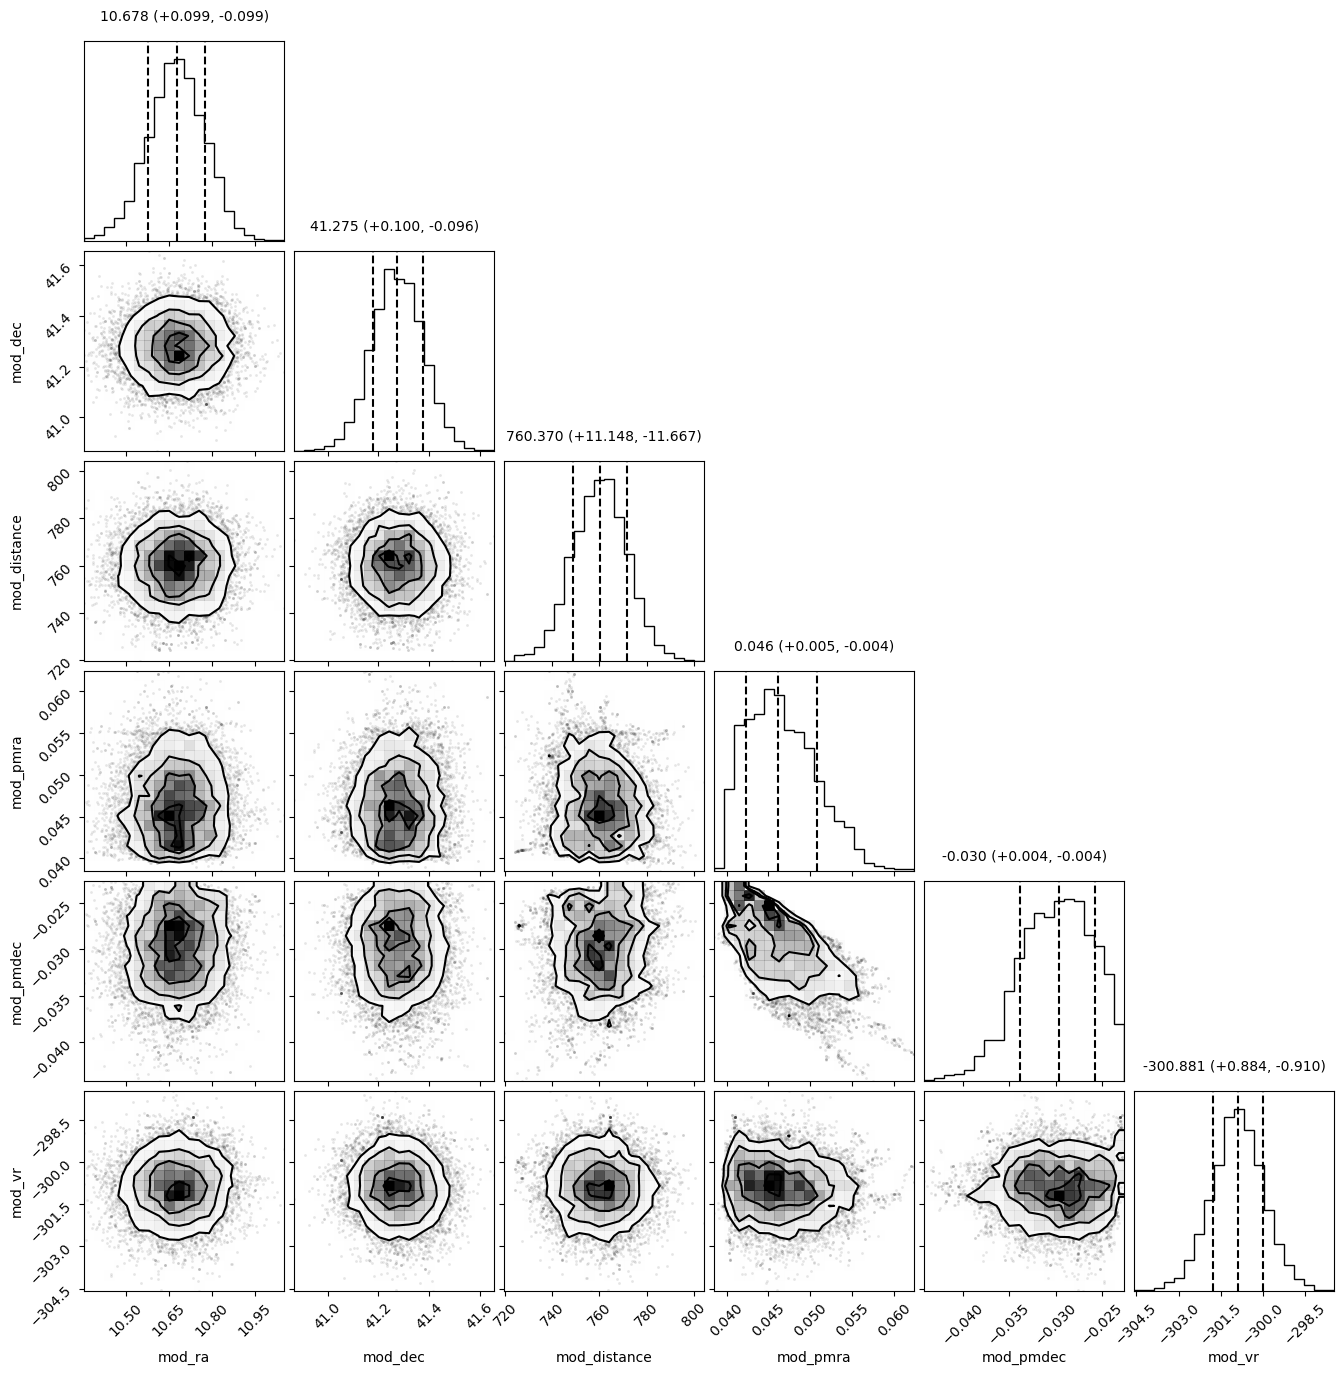

In [20]:
# 参数标签和初始猜测
labels = ['mod_ra', 'mod_dec', 'mod_distance','mod_pmra', 'mod_pmdec', 'mod_vr']

# 计算分位数
quantiles = [0.16, 0.5, 0.84]
percentiles = np.percentile(mods, [16, 50, 84], axis=0)

# 提取中位数和误差
medians = percentiles[1]
lower_errors = medians - percentiles[0]
upper_errors = percentiles[2] - medians

# 绘制角度分布
fig = corner.corner(mods, labels=labels,  quantiles=quantiles, fontsize=50)

# 在图中添加中位数和误差信息
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(len(labels)):
    ax = axes[i, i]
    text = f"{medians[i]:.3f} (+{upper_errors[i]:.3f}, -{lower_errors[i]:.3f})"
    ax.annotate(text, xy=(0.5, 1.1), xycoords="axes fraction", ha="center", fontsize=10)

plt.show()

In [7]:
rot = np.dot(rotation_matrix_theta(medians[4]), np.dot(rotation_matrix_phi(medians[5]), rotation_matrix_theta(medians[6])))
test = np.dot(rot, np.array([-300, 27, 0]))
print("test:", test)

NameError: name 'rotation_matrix_theta' is not defined

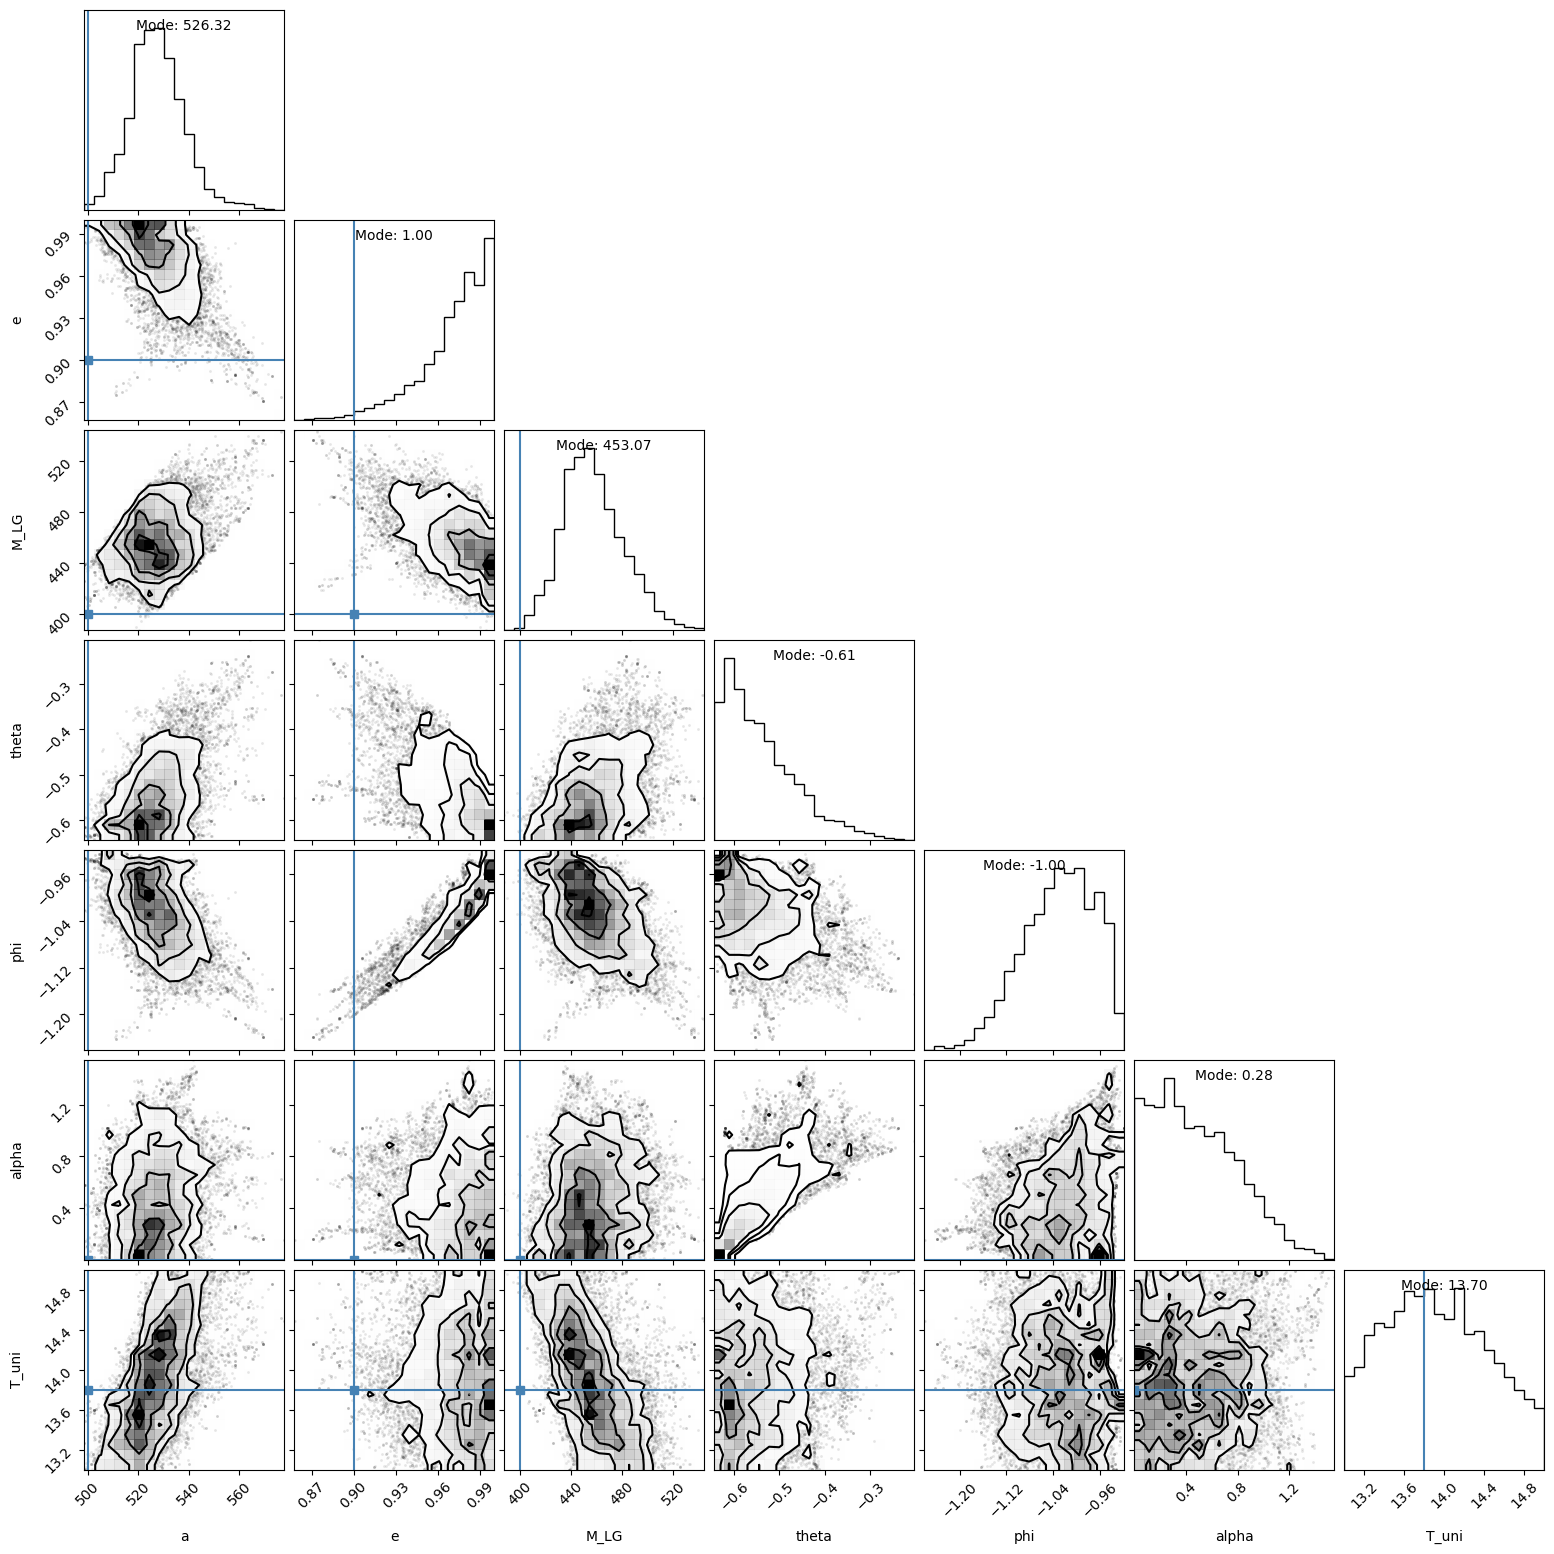

In [9]:
# 提取采样结果
burn_in = int(nsteps * 0.2) 
samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)

# 参数标签和初始猜测
labels = ["a", "e", "M_LG", "theta", "phi", "alpha", "T_uni"]

# 计算众数
def compute_mode(data, bins=30):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    max_idx = np.argmax(hist)
    mode = (bin_edges[max_idx] + bin_edges[max_idx + 1]) / 2
    return mode

modes = [compute_mode(samples[:, i]) for i in range(samples.shape[1])]

# 绘制角度分布
fig = corner.corner(samples, labels=labels, truths=initial_guess)

# 在图中添加众数信息
axes = np.array(fig.axes).reshape((len(labels), len(labels)))
for i in range(len(labels)):
    ax = axes[i, i]
    text = f"Mode: {modes[i]:.2f}"
    ax.annotate(text, xy=(0.5, 0.9), xycoords="axes fraction", ha="center", fontsize=10)

plt.show()

In [27]:
(530/43018/470)**(-1/2)/(1-0.97)*(1-0.97**2)**(1/2)

1582.736389291476

In [6]:
530*(1-0.97)

15.900000000000015

In [21]:
(530**3/43018/470)**(1/2)*2*np.pi

17.049813632222616